In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import linkage
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils import load_config, seed_everything, calculate_cv_per_class, calculate_d_ratio, calculate_detection_rate

In [2]:
# for reproducibility
seed_everything(42)

# config file
config = load_config("../configs/config.yaml")

# Set Seaborn style
sns.set(style=config['sns_params']['style'],
        palette=config['sns_params']['palette'],
        font_scale=config['sns_params']['font_scale'])

# Set Matplotlib parameters
plt.rcParams.update(config['plt_params'])

### Read files and take a first look

In [3]:
data_mat = pd.read_csv(config['paths']['data_mat_path'])
data_mat.head(5)

,sample,FT-000,FT-001,FT-002,FT-003,FT-004,FT-005,FT-006,FT-007,FT-008,...,FT-242,FT-243,FT-244,FT-245,FT-246,FT-247,FT-248,FT-249,FT-250,FT-251
0,20241106-297-Blank1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,20241106-297-Blank2,0.0,0.000000,0.0,5.770641,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.534493,0.0,0.0,0.0
2,20241106-297-Blank3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.469501,0.0,0.0,0.0
3,20241106-297-Blank4,0.0,5.497865,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,20241106-297-Blank5,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [4]:
feat_meta = pd.read_csv(config['paths']['feat_meta_path'])
feat_meta.head(5)

,feature,mz,mz max,mz min,mz std,rt,rt end,rt max,rt min,rt start,rt std
0,FT-000,359.108768,359.130591,359.090122,0.010955,543.846374,561.270879,546.697803,539.941156,528.714227,1.683901
1,FT-001,357.109546,357.130018,357.091871,0.010668,543.839157,563.021530,546.948017,540.038924,528.530311,1.662290
2,FT-002,889.649931,889.702216,889.601547,0.025552,609.099742,627.717251,611.746501,606.426553,596.789046,1.324647
3,FT-003,355.111928,355.132772,355.093653,0.010508,543.995269,566.951285,547.164503,540.681882,526.943213,1.609071
4,FT-004,888.645365,888.696941,888.600202,0.026161,609.255652,632.996442,612.008732,606.778809,595.461688,1.254684


In [5]:
sample_meta = pd.read_csv(config['paths']['sample_meta_path'])
sample_meta.head(5)

,sample,class,id,order,batch
0,20241106-297-Blank1,B,20241106-297-Blank1,1,1
1,20241106-297-Blank2,B,20241106-297-Blank2,2,1
2,20241106-297-Blank3,B,20241106-297-Blank3,3,1
3,20241106-297-Blank4,B,20241106-297-Blank4,102,1
4,20241106-297-Blank5,B,20241106-297-Blank5,103,1


In [6]:
exog_stand = pd.read_csv(config['paths']['exog_stan_path'])
exog_stand

,compound_id,mz,Retention_time
0,GU4,886.40,610
1,GU5,1048.45,753
2,GU14,1253.96,1500
3,GU15,1334.99,1551


### Some basic stats and plots

In [7]:
print(f'Number of missing values in data matrix: {data_mat.isna().sum().sum()}')

Number of missing values in data matrix: 0


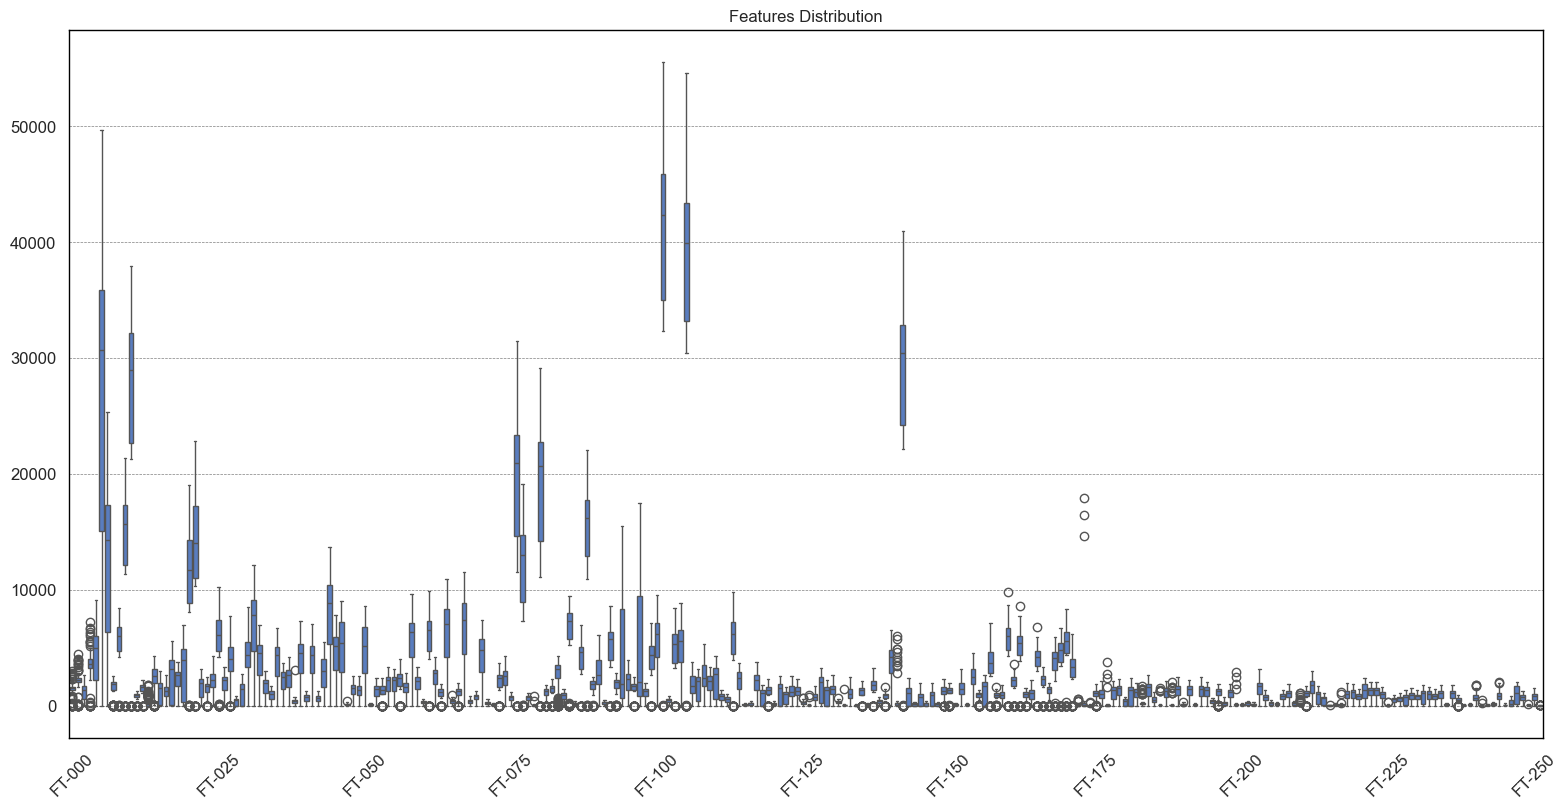

In [8]:
ft_columns = [col for col in data_mat.columns if col.startswith('FT')]

# Reshape the DataFrame to long format
long_df = data_mat[ft_columns].melt(var_name='Feature', value_name='Value')

# Create the box plot
plt.figure(figsize=(16, 8))
sns.boxplot(data=long_df, x='Feature', y='Value')

plt.title('Features Distribution')
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.xticks(ticks=range(0, len(ft_columns), 25), labels=[f'FT-{i:03}' for i in range(0, len(ft_columns), 25)], rotation=45)
plt.savefig(f"{config['paths']['figures_dir']}/features_distribution.png")
plt.show()

<Figure size 800x600 with 0 Axes>

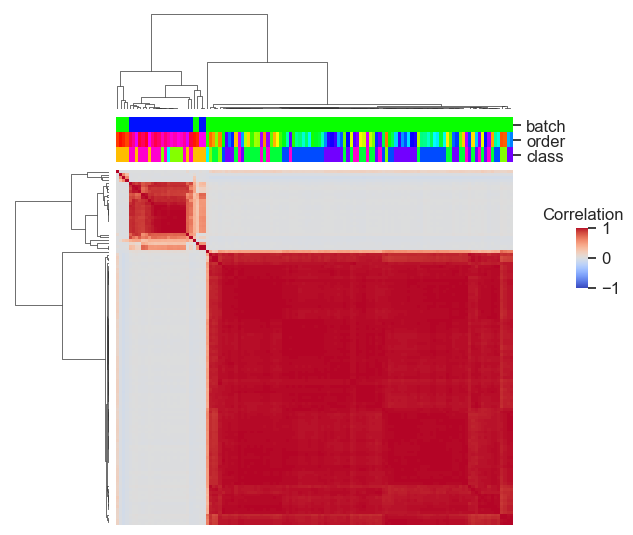

In [9]:
ft_columns = [col for col in data_mat.columns if col.startswith('FT')]

# Features pairwise correlations
corr_matrix = data_mat[ft_columns].T.corr()

# Compute linkage for clustering
linkage_matrix = linkage(corr_matrix, method='average')

# coloring by 
def create_color_mapping(column):
    unique_values = sample_meta[column].unique()
    palette = sns.color_palette("hsv", len(unique_values))  # Choose a palette (e.g., "hsv", "tab10")
    color_mapping = dict(zip(unique_values, palette))
    return sample_meta[column].map(color_mapping)

# Create row/column color annotations
batch_colors = create_color_mapping("batch")
class_colors = create_color_mapping("class")
order_colors = create_color_mapping("order")

# Combine into a DataFrame
row_col_colors = pd.DataFrame({
    "batch": batch_colors,
    'order': order_colors,
    "class": class_colors
})

# make plot
plt.figure()
g = sns.clustermap(
    corr_matrix, 
    row_linkage=linkage_matrix, 
    col_linkage=linkage_matrix, 
    cmap="coolwarm", 
    annot=False,
    vmin=-1,
    vmax=1,
    figsize=(6,6),
    col_colors=row_col_colors)

# Further customize tick label sizes
g.cax.set_position([0.98, 0.5, 0.02, 0.1]) 
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.cax.set_title("Correlation") 
plt.savefig(f"{config['paths']['figures_dir']}/samples_corr.png")
plt.show()

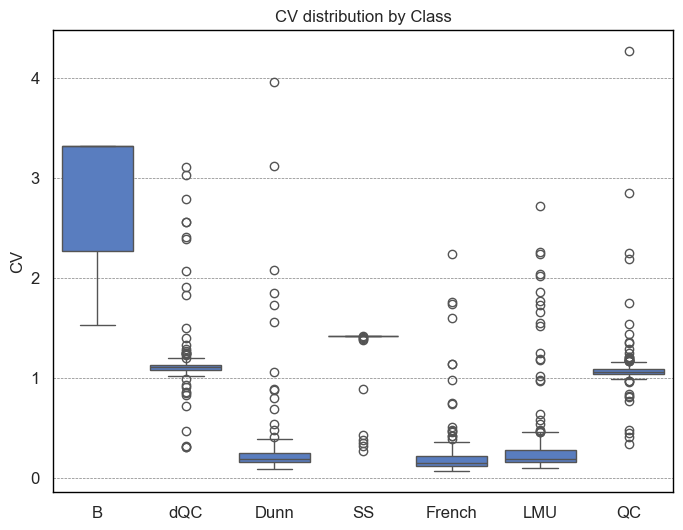

In [10]:
cv_df = calculate_cv_per_class(data_mat, sample_meta)

# Reshape the DataFrame to long format
cv_df_long = cv_df.melt(id_vars='class', value_vars=ft_columns, 
                  var_name='Feature', value_name='Value')

# Create the box plot
plt.figure()
sns.boxplot(data=cv_df_long, x='class', y='Value')
plt.title('CV distribution by Class')
plt.xlabel(None)
plt.ylabel('CV')
plt.savefig(f"{config['paths']['figures_dir']}/CV_per_class.png")
plt.show()

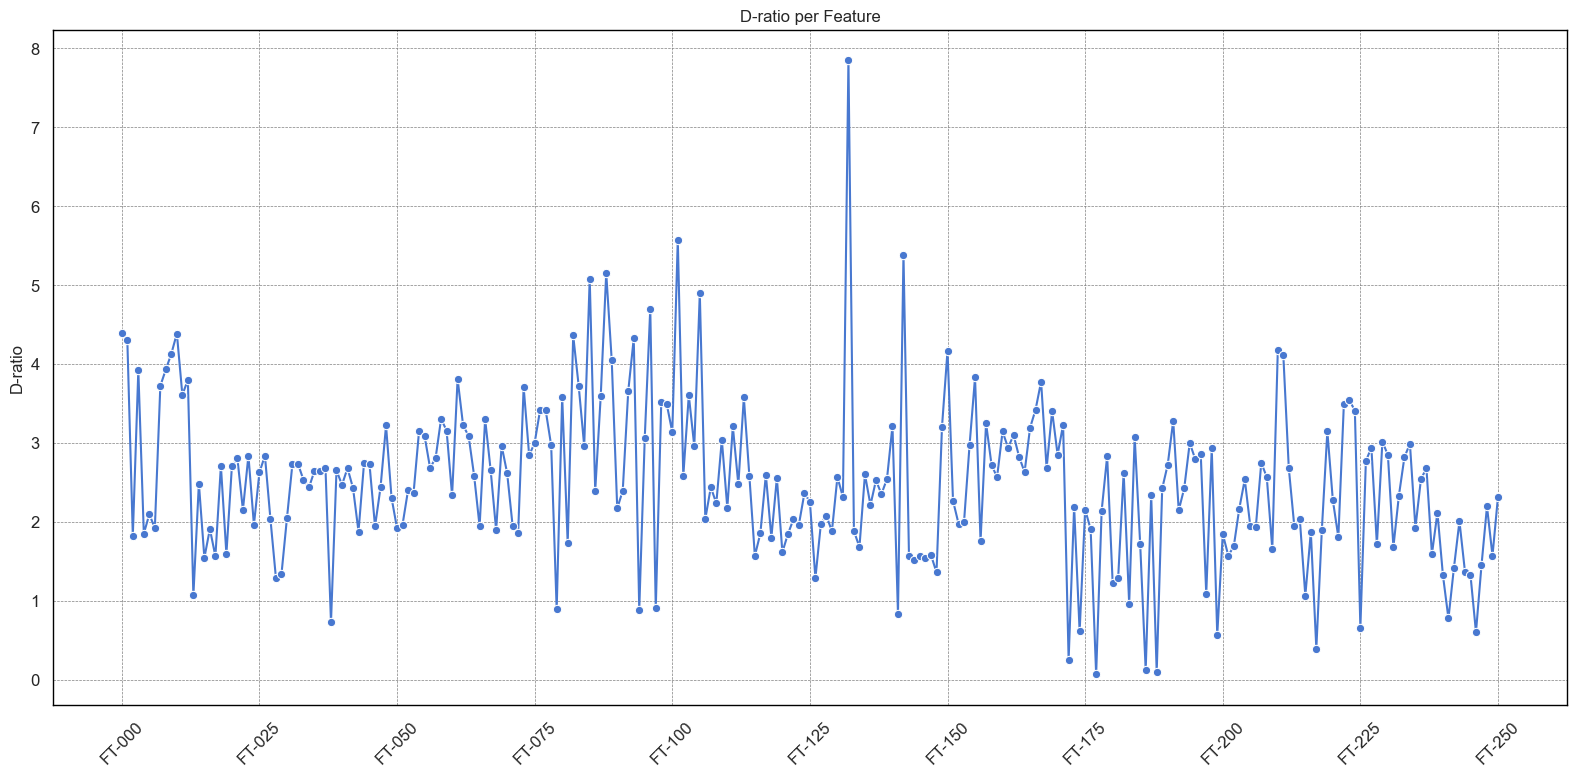

In [11]:
### Dratio

# Identify QC and biological samples from acquisition_list
qc_samples = sample_meta[sample_meta['class'].str.contains('QC')]['sample']
bio_samples = sample_meta[sample_meta['class'].isin(['Dunn', 'French', 'LMU'])]['sample']

# Combine results into a summary DataFrame
d_ratio = calculate_d_ratio(data_mat, qc_samples, bio_samples)

plt.figure(figsize=(16, 8))
sns.lineplot(data=d_ratio, x='Feature', y='D_Ratio', marker='o')
plt.title('D-ratio per Feature')
plt.xlabel(None)
plt.ylabel('D-ratio')
plt.xticks(ticks=range(0, len(ft_columns), 25), labels=[f'FT-{i:03}' for i in range(0, len(ft_columns), 25)], rotation=45)
plt.tight_layout()
plt.savefig(f"{config['paths']['figures_dir']}/Dratio_per_feature.png")
plt.show()

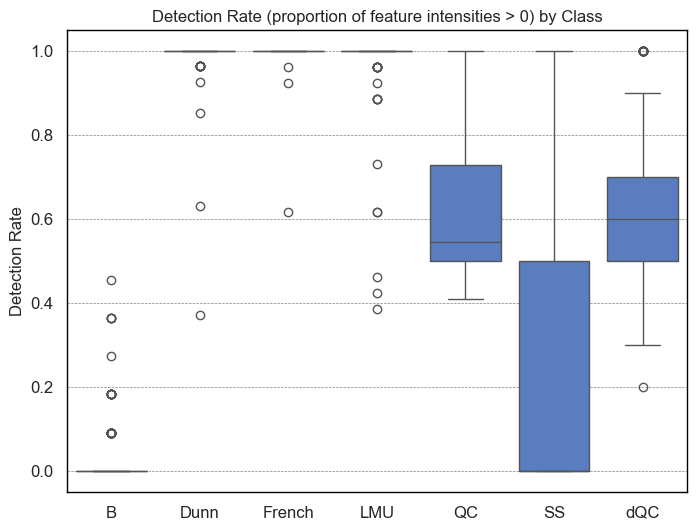

In [12]:
detection_rate = calculate_detection_rate(data_mat, sample_meta)

# Reshape the DataFrame to long format
detection_rate_long = detection_rate.melt(id_vars='class', value_vars=ft_columns, 
                  var_name='Feature', value_name='Value')

# Create the box plot
plt.figure()
sns.boxplot(data=detection_rate_long, x='class', y='Value')
plt.title('Detection Rate (proportion of feature intensities > 0) by Class')
plt.xlabel(None)
plt.ylabel('Detection Rate')
plt.savefig(f"{config['paths']['figures_dir']}/detection_rate_per_class.png")
plt.show()

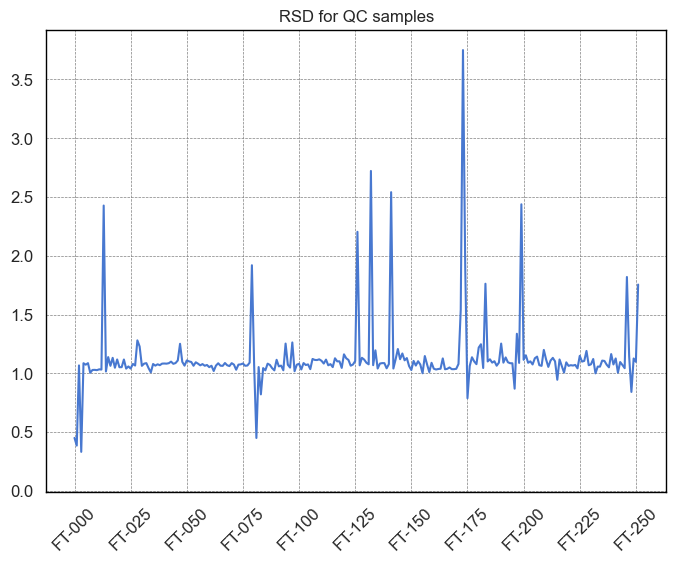

In [13]:
# Calculate RSD for QC samples
qc_samples = sample_meta[sample_meta['class'].str.contains('QC')]
qc_data = data_mat.loc[data_mat['sample'].isin(qc_samples['sample']), ft_columns]
rsd = qc_data.std(axis=0) / qc_data.mean(axis=0)

plt.figure()
rsd.plot(kind='line')
plt.xticks(ticks=range(0, len(rsd), 25), labels=[f'FT-{i:03}' for i in range(0, len(rsd), 25)], rotation=45)
plt.ylim(-.01, )
plt.title('RSD for QC samples')
plt.savefig(f"{config['paths']['figures_dir']}/rsd_for_qc_samples.png")
plt.show()

### Q1. How many features have been detected, how is the distribution across mz and retention time, and across classes?

In [14]:
print(f'Number of features: {data_mat.shape[1]-1}')
print(f'Number of samples: {data_mat.shape[0]}')

Number of features: 252
Number of samples: 124


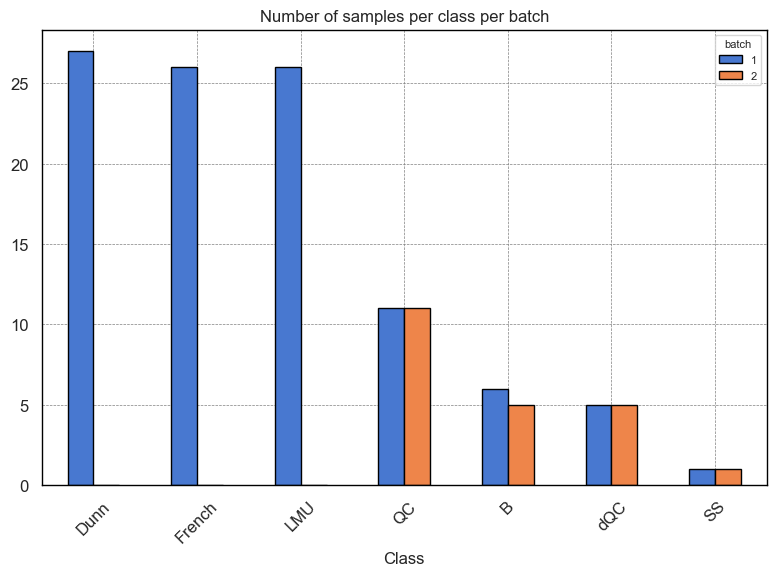

In [15]:
# Group and pivot the data
class_batch_counts = sample_meta.groupby(['class', 'batch']).size().unstack(fill_value=0)

# Sort by total count across batches
class_batch_counts['Total'] = class_batch_counts.sum(axis=1)
class_batch_counts = class_batch_counts.sort_values(by='Total', ascending=False).drop(columns='Total')

# Plot grouped bar plot
class_batch_counts.plot(kind='bar', edgecolor='black')
plt.title('Number of samples per class per batch')
plt.xlabel('Class')
plt.legend(title='batch')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{config['paths']['figures_dir']}/nsamples_perclass_perbatch.png")
plt.show()

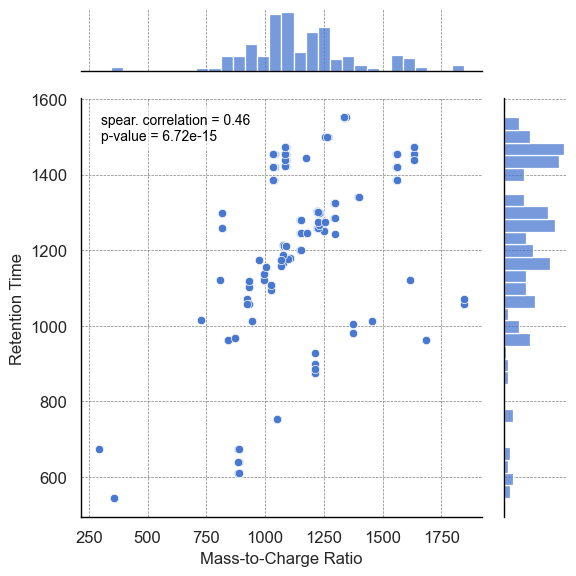

In [16]:
# Calculate correlation
spearman_corr, pval = spearmanr(feat_meta['mz'], feat_meta['rt'])

# Jointplot with marginal distributions
joint_plot = sns.jointplot(
    data=feat_meta,
    x='mz',
    y='rt',
    kind='scatter',
    marginal_kws=dict(bins=30, fill=True),
    space=0.2,
)

# Add correlation to plot
joint_plot.ax_joint.text(
    0.05, 0.9, f"spear. correlation = {spearman_corr:.2f}\np-value = {pval:.2e}", 
    transform=joint_plot.ax_joint.transAxes,
    fontsize=10, color="black", bbox=dict(facecolor='white', alpha=0.5)
)

joint_plot.set_axis_labels('Mass-to-Charge Ratio', 'Retention Time')
plt.tight_layout()
plt.savefig(f"{config['paths']['figures_dir']}/rt_vs_mz.png")
plt.show()


<Figure size 2000x1000 with 0 Axes>

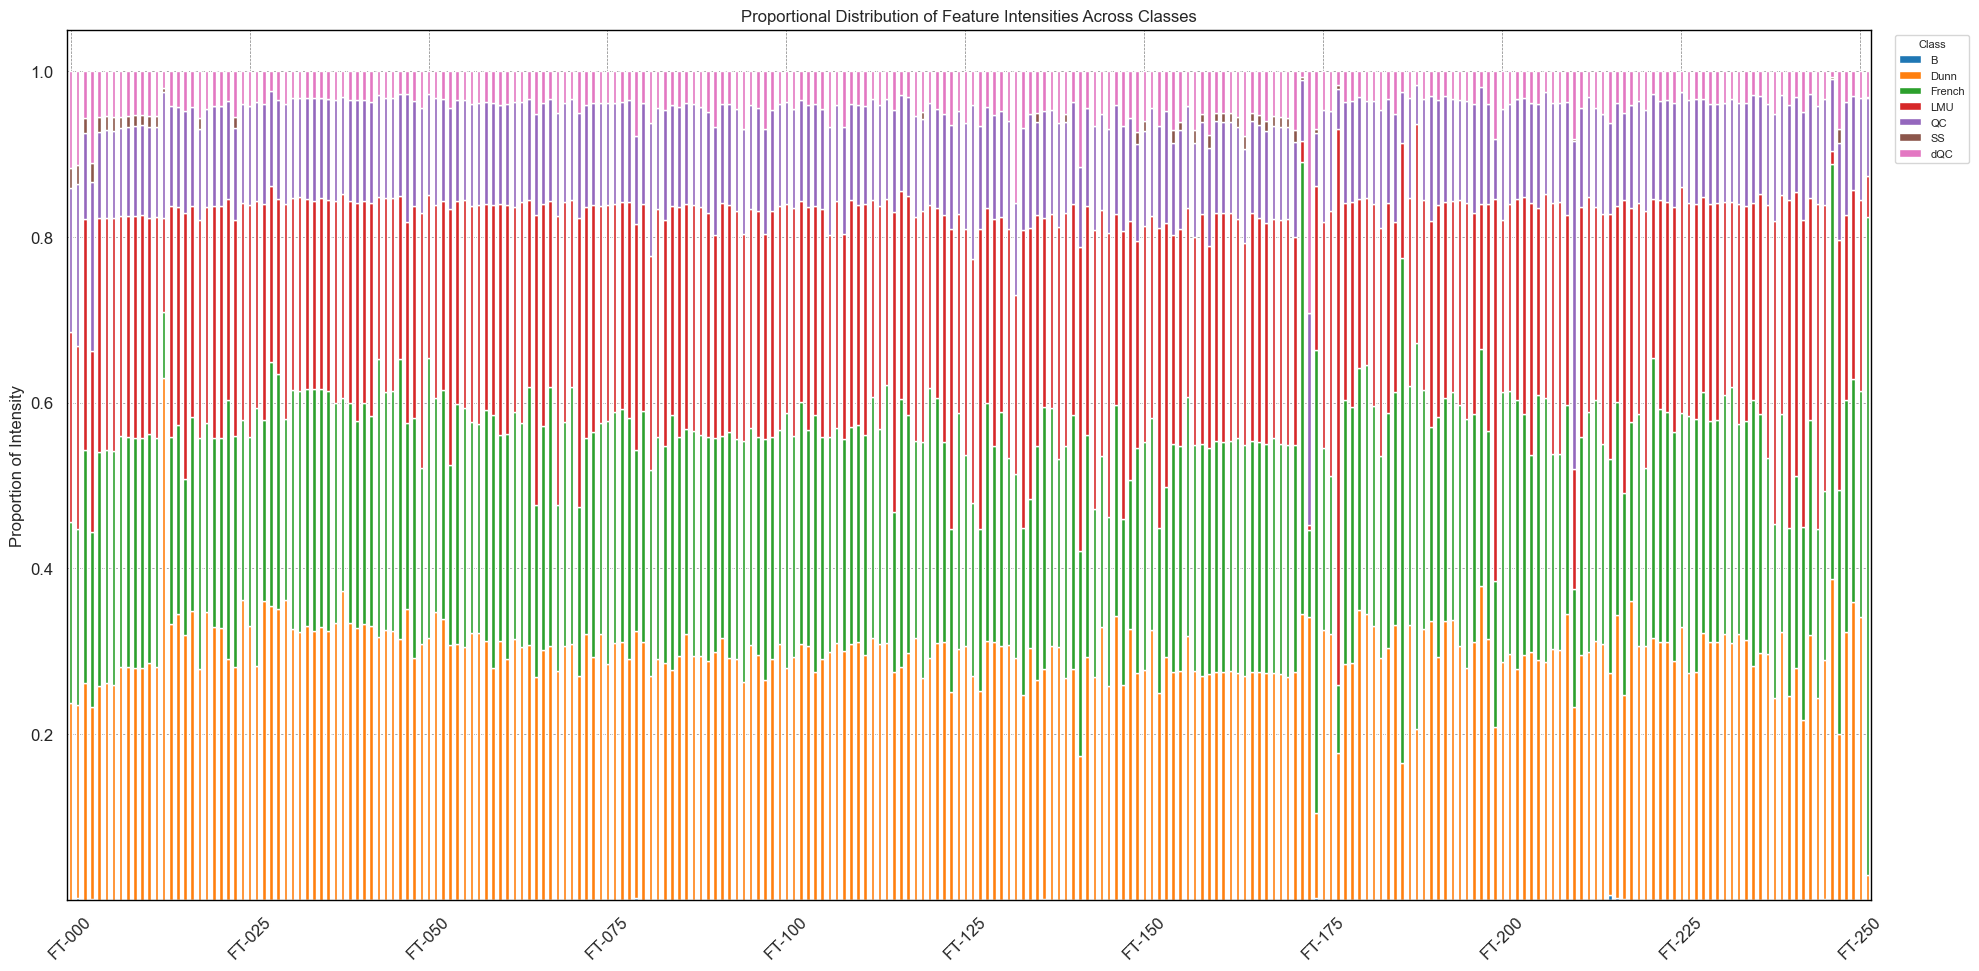

In [17]:
# Melt data_matrix for class-level analysis
intensity_long = data_mat.melt(id_vars='sample', var_name='feature', value_name='intensity')

# Merge with acquisition_list to add class labels
intensity_long = intensity_long.merge(sample_meta[['sample', 'class']], on='sample')

# Calculate the total intensity for each feature by class
feature_class_intensity = intensity_long.groupby(['feature', 'class'])['intensity'].sum().unstack(fill_value=0)

# Calculate the proportion of intensity per class for each feature
feature_class_proportions = feature_class_intensity.div(feature_class_intensity.sum(axis=1), axis=0)

# Plot the proportional stacked bar plot
plt.figure(figsize=(20, 10))
feature_class_proportions.plot(kind='bar', stacked=True, figsize=(20, 10), color=sns.color_palette("tab10"))

plt.title('Proportional Distribution of Feature Intensities Across Classes')
plt.xlabel(None)
plt.ylabel('Proportion of Intensity')
plt.legend(title='Class', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.xticks(ticks=range(0, len(ft_columns), 25), labels=[f'FT-{i:03}' for i in range(0, len(ft_columns), 25)], rotation=45)
plt.savefig(f"{config['paths']['figures_dir']}/prop_intensities_in_classes.png")
plt.show()

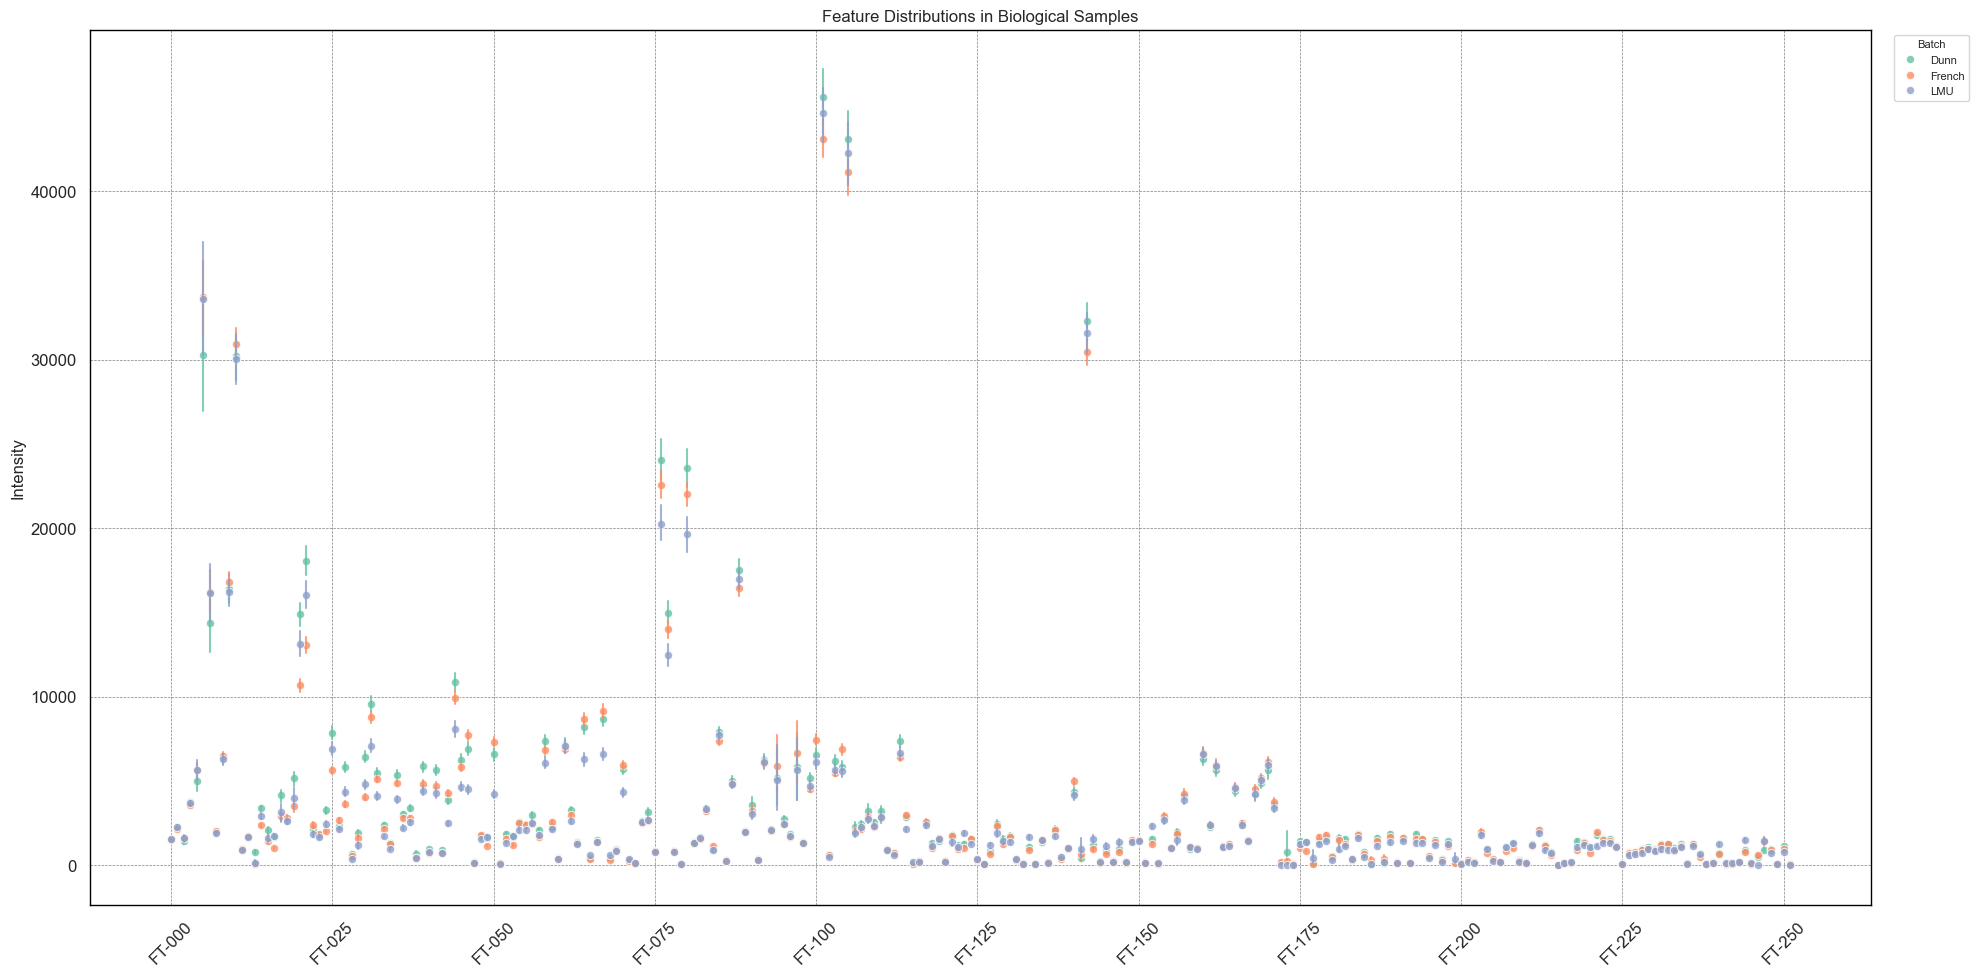

In [18]:
intensity_long_bio = intensity_long[intensity_long['class'].isin(['French', 'LMU', 'Dunn'])]

plt.figure(figsize=(20, 10))
sns.lineplot(data=intensity_long_bio, x='feature', y='intensity', hue='class', alpha=0.8, palette = 'Set2', linestyle='', err_style='bars', marker='o')
plt.title('Feature Distributions in Biological Samples')
plt.xlabel(None)
plt.ylabel('Intensity')
plt.xticks(ticks=range(0, len(ft_columns), 25), labels=[f'FT-{i:03}' for i in range(0, len(ft_columns), 25)], rotation=45)
plt.legend(title='Batch', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{config['paths']['figures_dir']}/feature_distribution_in_bio_samples.png")
plt.show()

### 2. How is the contamination in the experiment?

In [19]:
# extract Blank samples
data_mat_blank = data_mat.merge(sample_meta[['sample', 'class', 'batch']], how='left')
data_mat_blank = data_mat_blank[data_mat_blank['class'] == 'B']
ft_columns = [col for col in data_mat.columns if col.startswith('FT')]
data_mat_blank_melt = data_mat_blank[ft_columns + ['sample', 'batch']].melt(id_vars=['sample', 'batch'], var_name='feature', value_name='intensity')

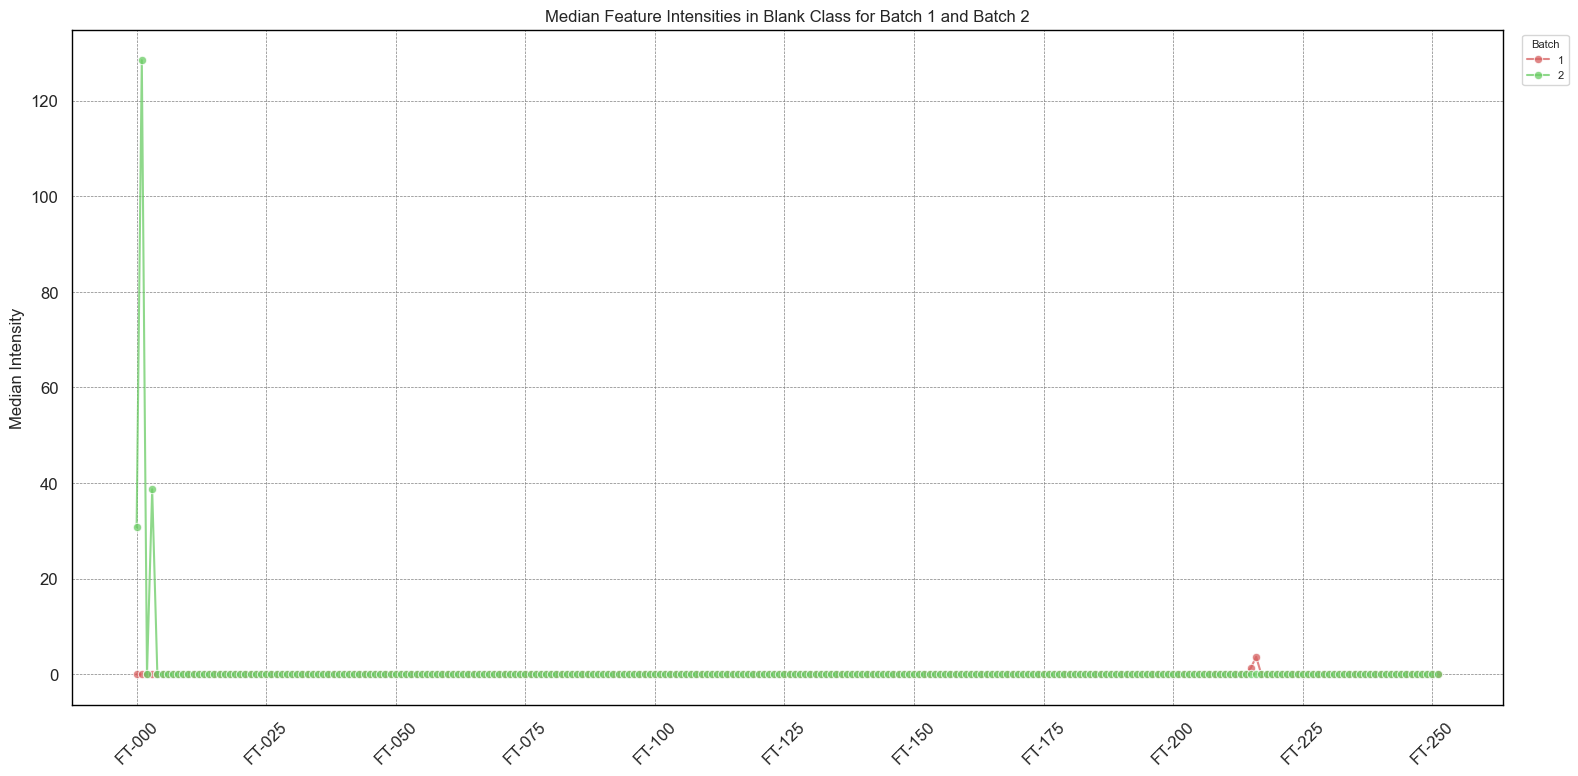

In [20]:
mean_intensities = data_mat_blank_melt.groupby(['feature', 'batch'])['intensity'].median().reset_index()

plt.figure(figsize=(16, 8))
sns.lineplot(data=mean_intensities, x='feature', y='intensity', hue='batch', marker='o', alpha=0.75, palette=['r', 'g'])
plt.title('Median Feature Intensities in Blank Class for Batch 1 and Batch 2')
plt.xlabel(None)
plt.ylabel('Median Intensity')
plt.xticks(ticks=range(0, len(rsd), 25), labels=[f'FT-{i:03}' for i in range(0, len(rsd), 25)], rotation=45)
plt.legend(title='Batch', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{config['paths']['figures_dir']}/median_blank_intensity_features.png")
plt.show()

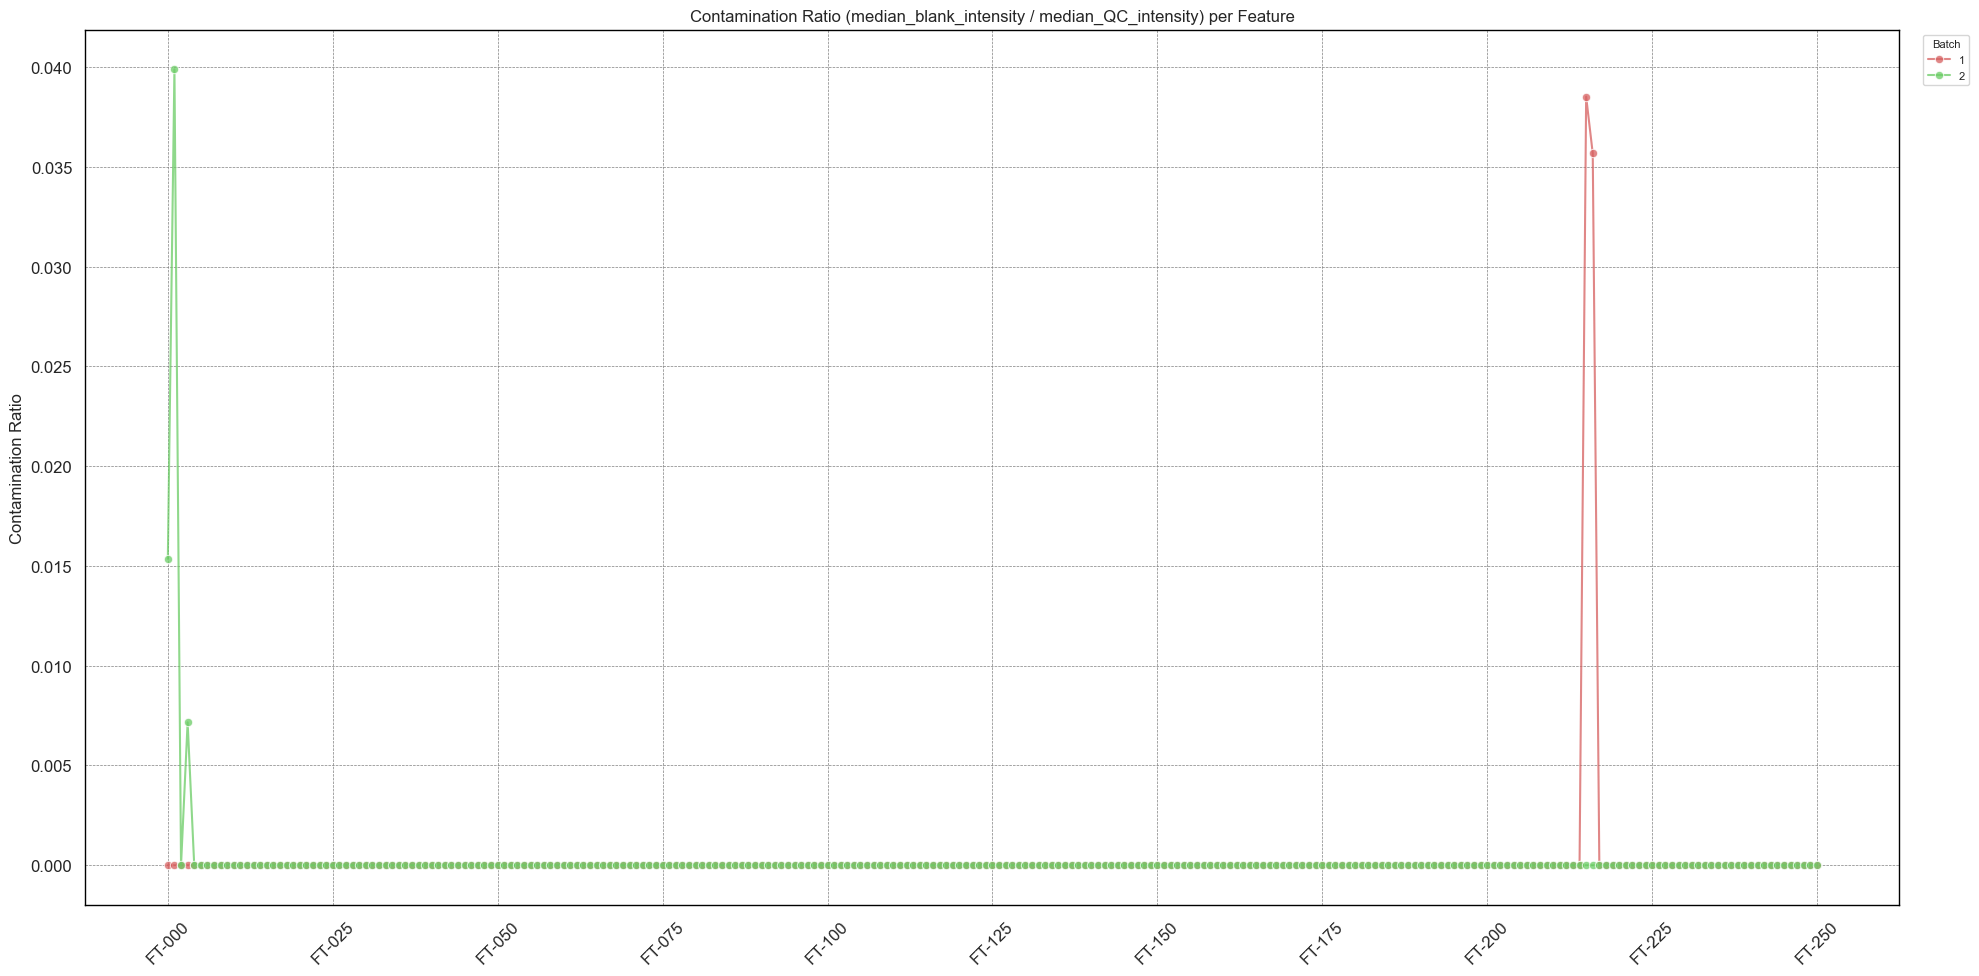

In [21]:
# Merge sample metadata with data_matrix
data_mat2 = data_mat.merge(sample_meta[['sample', 'class', 'batch']], on='sample', how='left')

# Create an empty DataFrame to store batch-level contamination ratios
batch_contamination_df = pd.DataFrame()

# Loop through each batch
for batch in data_mat2['batch'].unique():
    if pd.isna(batch):
        continue
    
    # Subset Blank and Non-Blank samples for the current batch
    blank_samples_batch = data_mat2[(data_mat2['class'].str.contains('B')) & (data_mat2['batch'] == batch)]
    non_blank_samples_batch = data_mat2[(data_mat2['class'].str.contains('QC')) & (data_mat2['batch'] == batch)]
    
    # Calculate median intensity per feature
    blank_means_batch = blank_samples_batch.iloc[:, 1:-3].median(axis=0)  # Exclude metadata columns
    non_blank_means_batch = non_blank_samples_batch.iloc[:, 1:-3].median(axis=0)  # Exclude metadata columns
    
    # Create a temporary DataFrame for this batch
    contamination_batch = pd.DataFrame({
        'Feature': blank_samples_batch.columns[1:-3],
        f'Blank_Mean_Intensity_Batch_{batch}': blank_means_batch.values,
        f'Non_Blank_Mean_Intensity_Batch_{batch}': non_blank_means_batch.values,
    })
    
    # Calculate contamination ratio for this batch
    contamination_batch[f'Contamination_Ratio_Batch_{batch}'] = (
        contamination_batch[f'Blank_Mean_Intensity_Batch_{batch}'] / 
        (contamination_batch[f'Non_Blank_Mean_Intensity_Batch_{batch}'] + 1e-6)
    )
    
    # Merge batch data into the main contamination DataFrame
    if batch_contamination_df.empty:
        batch_contamination_df = contamination_batch
    else:
        batch_contamination_df = batch_contamination_df.merge(contamination_batch, on='Feature', how='outer')

# Prepare data for line plot visualization
# Melt the contamination DataFrame to long format for plotting
contamination_long = pd.melt(
    batch_contamination_df,
    id_vars='Feature',
    value_vars=[col for col in batch_contamination_df.columns if 'Contamination_Ratio' in col],
    var_name='Batch',
    value_name='Contamination_Ratio'
)

# Extract batch numbers for coloring
contamination_long['Batch'] = contamination_long['Batch'].str.extract(r'Batch_(\d+)').astype(int)

# Plot contamination ratios as a line plot, colored by batch
plt.figure(figsize=(20, 10))
sns.lineplot(
    data=contamination_long,
    x='Feature',
    y='Contamination_Ratio',
    hue='Batch',
    marker='o',
    palette=['r', 'g'],
    alpha=0.75
)
plt.title('Contamination Ratio (median_blank_intensity / median_QC_intensity) per Feature')
plt.xlabel(None)
plt.ylabel('Contamination Ratio')
plt.legend(title='Batch', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks(ticks=range(0, len(ft_columns), 25), labels=[f'FT-{i:03}' for i in range(0, len(ft_columns), 25)], rotation=45)
plt.tight_layout()
plt.savefig(f"{config['paths']['figures_dir']}/contamination_ratio_features.png")
plt.show()


### 3. Are the standards detected consistently across the experiment?

In [22]:
# Match exogenous standards to features based on m/z and retention time (rt)
# Allow a small tolerance for matching (e.g., ±0.1 for m/z and ±10s for rt)
mz_tolerance = 0.5
rt_tolerance = 10

# Initialize a list to store matched features
matched_standards = []

for index, standard in exog_stand.iterrows():
    matched = feat_meta[
        (feat_meta['mz'].between(standard['mz'] - mz_tolerance, standard['mz'] + mz_tolerance)) &
        (feat_meta['rt'].between(standard['Retention_time'] - rt_tolerance, standard['Retention_time'] + rt_tolerance))
    ]
    if not matched.empty:
        for _, row in matched.iterrows():
            matched_standards.append({
                'compound_id': standard['compound_id'],
                'expected_mz': standard['mz'],
                'expected_rt': standard['Retention_time'],
                'feature': row['feature'],
                'observed_mz': row['mz'],
                'observed_rt': row['rt']
            })

# Create a DataFrame of matched standards
matched_standards_df = pd.DataFrame(matched_standards)

# Merge with data_matrix to extract intensities across samples
if not matched_standards_df.empty:
    standard_features = matched_standards_df['feature'].unique()
    standards_data = data_mat[['sample'] + list(standard_features)]
    
    # Melt data for visualization
    standards_long = standards_data.melt(id_vars='sample', var_name='feature', value_name='intensity')
    standards_long = standards_long.merge(matched_standards_df[['feature', 'compound_id']], on='feature')
    print("Standards Matched in Feature Data:\n")
    print(matched_standards_df)

else:
    matched_standards_df = pd.DataFrame(columns=['compound_id', 'expected_mz', 'expected_rt', 'feature', 'observed_mz', 'observed_rt'])
    print("No Standards Matched in Feature Data")


Standards Matched in Feature Data:

  compound_id  expected_mz  expected_rt feature  observed_mz  observed_rt
0         GU4       886.40          610  FT-005   886.632460   609.461289
1         GU5      1048.45          753  FT-010  1048.724800   753.824614
2        GU14      1253.96         1500  FT-162  1254.277029  1499.404825
3        GU15      1334.99         1551  FT-169  1335.323637  1551.257112


In [45]:
ss_cv_df = cv_df.loc[cv_df['class']=='SS', matched_standards_df['feature'].values.tolist()]
print(f'the CV for SS samples are:\n {ss_cv_df}')

the CV for SS samples are:
      FT-005    FT-010    FT-162    FT-169
3  1.414214  1.414214  1.414214  1.414214


In [46]:
ss_detection_rate_df = detection_rate.loc[detection_rate['class']=='SS', matched_standards_df['feature'].values.tolist()]
print(f'the detection rate for SS samples are:\n {ss_detection_rate_df}')

the detection rate for SS samples are:
    FT-005  FT-010  FT-162  FT-169
5     0.5     0.5     0.5     0.5


In [60]:
ss_d_ratio = d_ratio.loc[d_ratio['Feature'].isin(matched_standards_df['feature'].values.tolist()), ['Feature', 'D_Ratio']]
print(f'the D-Ratio for exogenous compounds are:\n {ss_d_ratio}')

the D-Ratio for exogenous compounds are:
     Feature   D_Ratio
5    FT-005  2.094086
10   FT-010  4.382207
162  FT-162  3.097478
169  FT-169  3.399818


### 4. How is the distribution of intensities across the classes? Are there any trends with respect to classes, batches, run order?

In [23]:
# Calculate total intensity per sample
data_mat['total_intensity'] = data_mat.iloc[:, 1:].sum(axis=1)

# Merge total intensity with acquisition_list metadata
intensity_metadata = data_mat[['sample', 'total_intensity']].merge(sample_meta, on='sample')

In [24]:
# PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_mat.iloc[:, 1:])
sample_meta['PCA1'] = pca_results[:, 0]
sample_meta['PCA2'] = pca_results[:, 1]

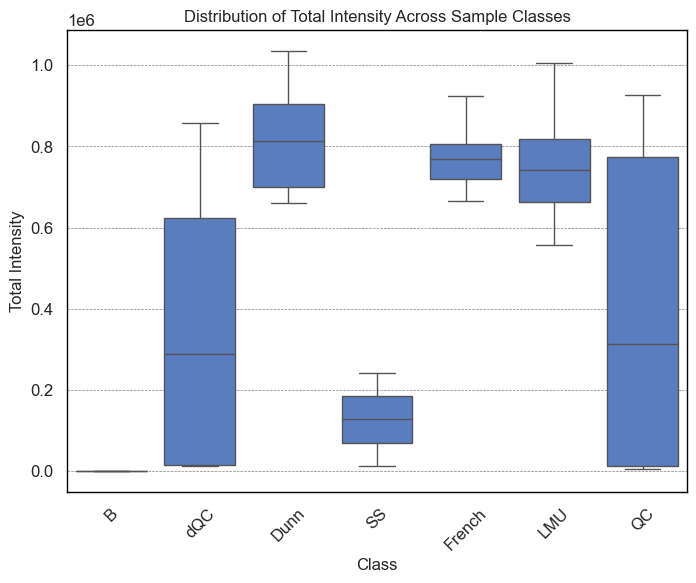

In [25]:
plt.figure()
sns.boxplot(data=intensity_metadata, x='class', y='total_intensity')
plt.title('Distribution of Total Intensity Across Sample Classes')
plt.xlabel('Class')
plt.ylabel('Total Intensity')
plt.xticks(rotation=45)
plt.savefig(f"{config['paths']['figures_dir']}/intensity_by_class.png")
plt.show()

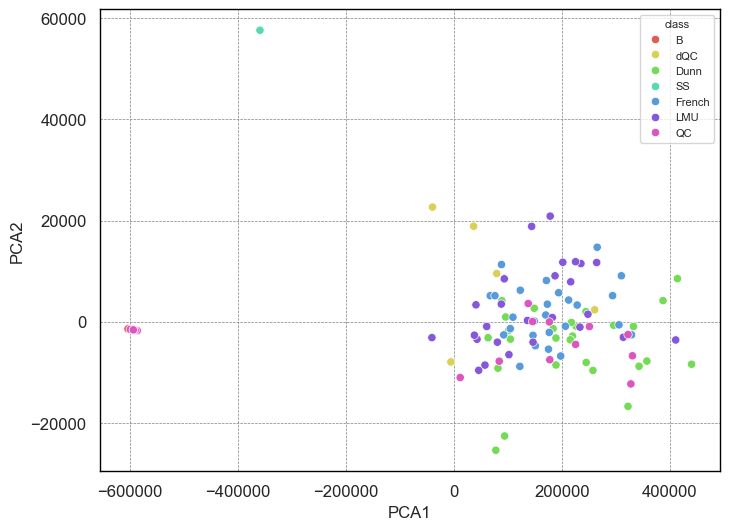

In [26]:
plt.figure()
sns.scatterplot(data=sample_meta, x='PCA1', y='PCA2', hue='class', palette='hls') # PCA colored by class
plt.savefig(f"{config['paths']['figures_dir']}/pca_by_class.png")
plt.show()


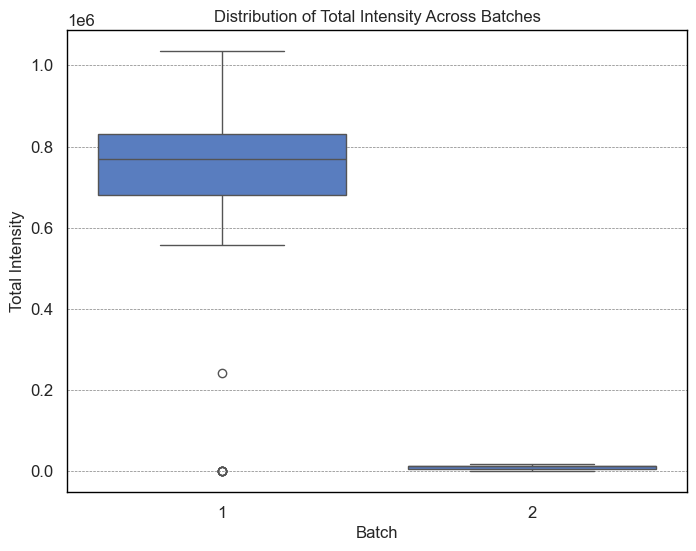

In [27]:
plt.figure()
sns.boxplot(data=intensity_metadata, x='batch', y='total_intensity')
plt.title('Distribution of Total Intensity Across Batches')
plt.xlabel('Batch')
plt.ylabel('Total Intensity')
plt.savefig(f"{config['paths']['figures_dir']}/intensity_by_batch.png")
plt.show()

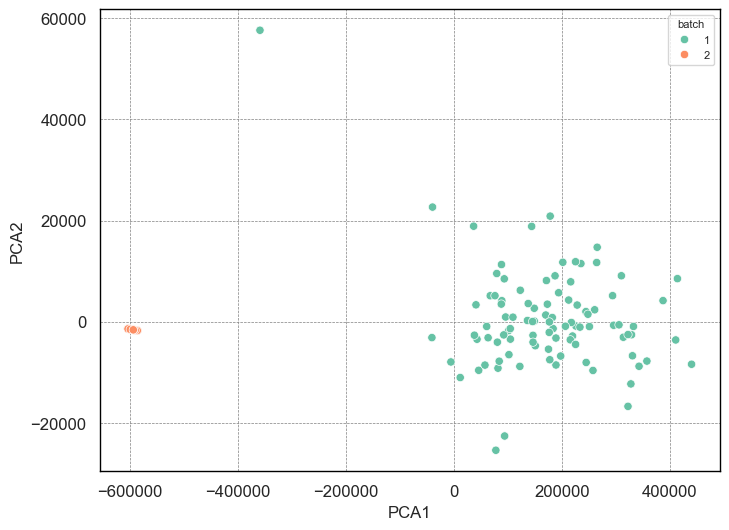

In [28]:

plt.figure()
sns.scatterplot(data=sample_meta, x='PCA1', y='PCA2', hue='batch', palette='Set2') # PCA colored by batch
plt.savefig(f"{config['paths']['figures_dir']}/pca_by_batch.png")
plt.show()

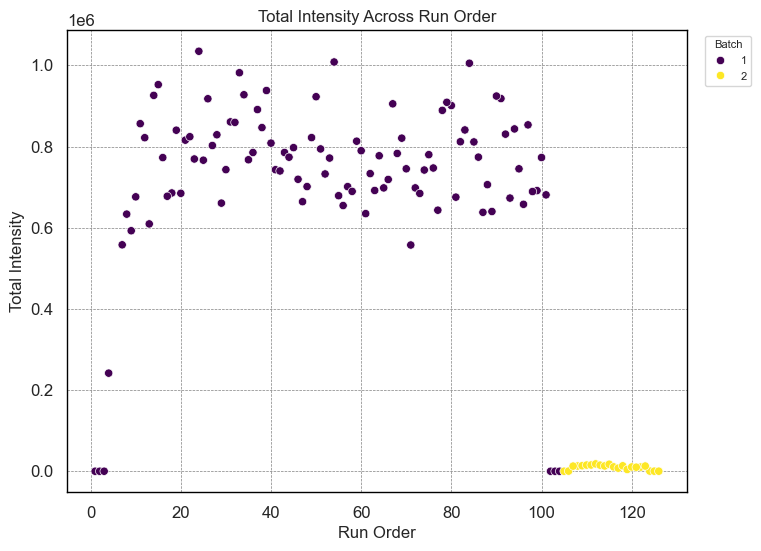

In [29]:
plt.figure()
sns.scatterplot(data=intensity_metadata, x='order', y='total_intensity', hue='batch', palette='viridis')
plt.title('Total Intensity Across Run Order')
plt.xlabel('Run Order')
plt.ylabel('Total Intensity')
plt.legend(title='Batch', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.savefig(f"{config['paths']['figures_dir']}/intensity_by_order.png")
plt.show()

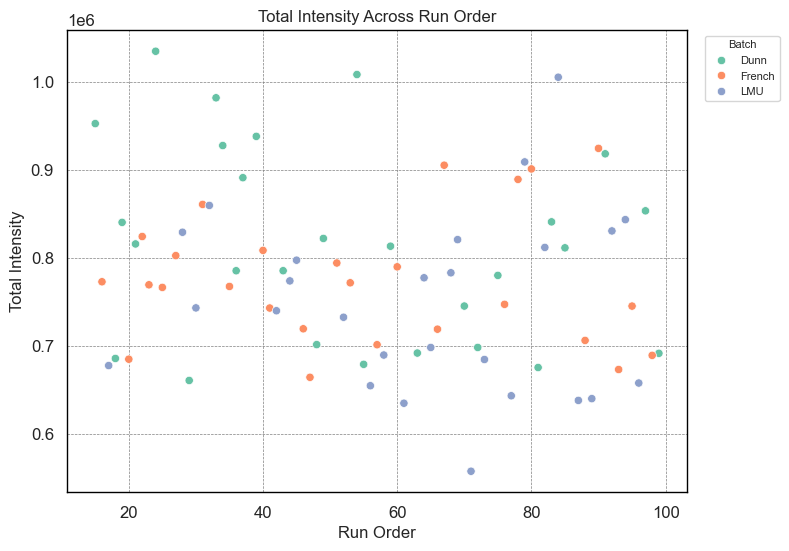

In [67]:
plt.figure()
sns.scatterplot(data=intensity_metadata[intensity_metadata['class'].isin(['LMU', 'French', 'Dunn'])], x='order', y='total_intensity', hue='class', palette='Set2')
plt.title('Total Intensity Across Run Order')
plt.xlabel('Run Order')
plt.ylabel('Total Intensity')
plt.legend(title='Batch', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.savefig(f"{config['paths']['figures_dir']}/intensity_by_order_biosamples.png")
plt.show()

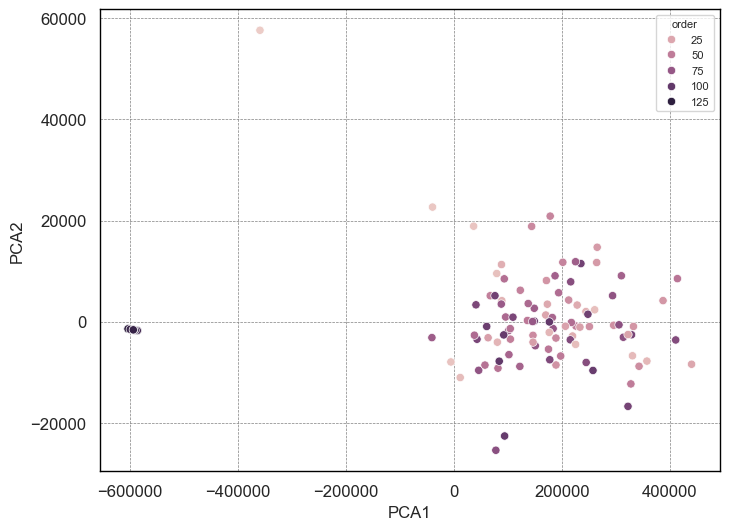

In [30]:

plt.figure()
sns.scatterplot(data=sample_meta, x='PCA1', y='PCA2', hue='order') # PCA colored by order
plt.savefig(f"{config['paths']['figures_dir']}/pca_by_order.png")
plt.show()

In [88]:
model = ols(formula='total_intensity ~ classes + order + batch', data=intensity_metadata.rename(columns={'class': 'classes'}, inplace=False)).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_df = pd.DataFrame(anova_table)
anova_df.to_csv('../results/misc/anova_res.csv')
anova_df

,sum_sq,df,F,PR(>F)
classes,2.573186e+12,6.0,23.896382,3.360524e-18
order,1.650887e+10,1.0,0.919877,3.395195e-01
batch,1.571891e+12,1.0,87.586018,8.092252e-16
Residual,2.063885e+12,115.0,NaN,NaN


### 5. What differences are there between sample classes and/or QCs? Is it consistent across batches?

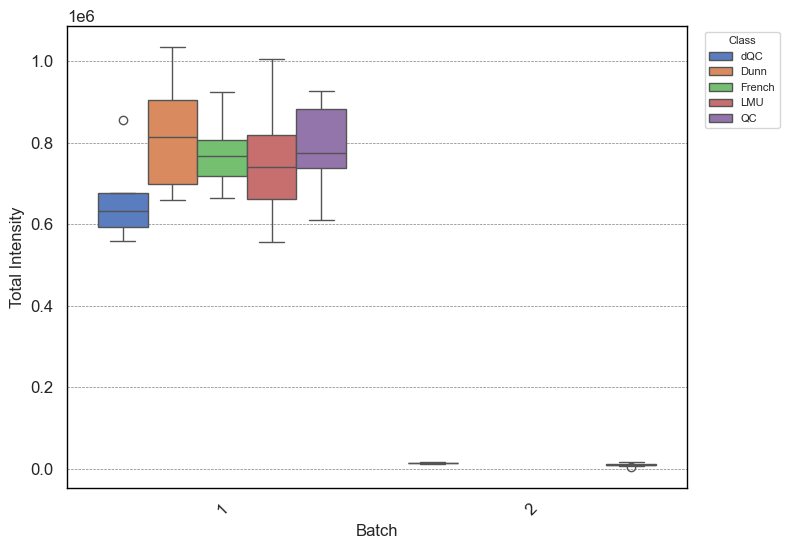

In [31]:
# Plot Intensity Distribution Across Classes Within Each Batch
plt.figure()
sns.boxplot(data=intensity_metadata[~intensity_metadata['class'].isin(['B', 'SS'])], x='batch', y='total_intensity', hue='class')
plt.xlabel('Batch')
plt.ylabel('Total Intensity')
plt.legend(title='Class', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.savefig(f"{config['paths']['figures_dir']}/sample_vs_qc_intensities_by_batch.png")
plt.show()


In [119]:
intensity_metadata_batch1 = intensity_metadata[(~intensity_metadata['class'].isin(['B', 'SS'])) & (intensity_metadata['batch']==1)]

tukey = pairwise_tukeyhsd(
    endog=intensity_metadata_batch1['total_intensity'],  # Dependent variable
    groups=intensity_metadata_batch1['class'],          # Grouping variable
    alpha=0.05                     # Significance level
)

tukey_df = pd.DataFrame(tukey.summary()[1:], columns=tukey.summary()[0])
tukey_df.to_csv('../results/misc/tukey_batch1.csv')
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Dunn,French,-41285.0144,0.5525,-116912.9668,34342.938,False
1,Dunn,LMU,-68507.0521,0.0948,-144135.0045,7120.9003,False
2,Dunn,QC,-20610.9187,0.9773,-119063.3708,77841.5334,False
3,Dunn,dQC,-152570.7161,0.0174,-286575.7363,-18565.696,True
4,French,LMU,-27222.0377,0.858,-103560.1273,49116.0519,False
5,French,QC,20674.0957,0.9775,-78324.9046,119673.096,False
6,French,dQC,-111285.7017,0.1529,-245692.7781,23121.3746,False
7,LMU,QC,47896.1334,0.6628,-51102.8669,146895.1337,False
8,LMU,dQC,-84063.664,0.4144,-218470.7404,50343.4123,False
9,QC,dQC,-131959.7974,0.1057,-280413.697,16494.1021,False


In [120]:
intensity_metadata_batch2 = intensity_metadata[(~intensity_metadata['class'].isin(['B', 'SS'])) & (intensity_metadata['batch']==2)]

tukey = pairwise_tukeyhsd(
    endog=intensity_metadata_batch2['total_intensity'],  # Dependent variable
    groups=intensity_metadata_batch2['class'],          # Grouping variable
    alpha=0.05                     # Significance level
)

tukey_df = pd.DataFrame(tukey.summary()[1:], columns=tukey.summary()[0])
tukey_df.to_csv('../results/misc/tukey_batch2.csv')
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,QC,dQC,3657.5286,0.0507,-11.9893,7327.0464,False
